## 1. Project setup


In [1]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import requests
import re
import unidecode

from pysal.model import spreg
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import seaborn as sns
sns.set(style='whitegrid', palette='pastel', color_codes=True) 
sns.mpl.rc('figure', figsize=(10,10))

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from esda.moran import Moran_Local
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

#Display every call in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a f

## 2. Create the dataset


### Create the covid geopandas dataframe


In [4]:
# Read the shapefile with all Romania's ATUs
ro_atu = gpd.read_file(os.path.join('data', 'ro_atu.shp'))
ro_atu.shape
ro_atu.head(2)

(3181, 2)

,siruta,geometry
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24..."
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581...."


In [5]:
# Get dataset data for daily covid statistics

url = "https://covid-large-html.csaladen.es/panels/new_uat_numbers.json"
covid_dataset_updated = requests.get(url).json()
covid_dataset_updated[0]

{'⚫': 0,
 '🌄': 'Teleorman',
 '🏠': 'Năsturelu',
 '📆': '2021-03-01 00:00:00',
 '📈': 0.81,
 '🔴': '< 1 ‰'}

In [6]:
print('Dimension of dataset:', len(covid_dataset_updated))
print('Column names:', covid_dataset_updated[0].keys())
print('Most recent recording of dataset:', covid_dataset_updated[-1])
print('Oldest recording of dataset:', covid_dataset_updated[0])

Dimension of dataset: 238800
Column names: dict_keys(['🌄', '🏠', '📈', '🔴', '⚫', '📆'])
Most recent recording of dataset: {'🌄': 'Teleorman', '🏠': 'Drăgănești-Vlașca', '📈': 0.26, '🔴': '< 1 ‰', '⚫': 0, '📆': '2021-05-14 00:00:00'}
Oldest recording of dataset: {'🌄': 'Teleorman', '🏠': 'Năsturelu', '📈': 0.81, '🔴': '< 1 ‰', '⚫': 0, '📆': '2021-03-01 00:00:00'}


Romanian Government only provided COVID-19 statistcs at the UAT level starting with 01.03.2021.

In [8]:
# Create a dataframe
covid_df = pd.DataFrame(covid_dataset_updated)
covid_df = covid_df.rename(columns = {covid_df.columns[0]:'county', covid_df.columns[1]: 'uat', covid_df.columns[2]: 'covid_rate', covid_df.columns[-1]: 'date'})
covid_df = covid_df[['county', 'uat', 'covid_rate', 'date']]
covid_df['date'] = covid_df['date'].apply(lambda x: x[:10]) # no need for time
covid_df.shape
covid_df.head(2)

(238800, 4)

,county,uat,covid_rate,date
0,Teleorman,Năsturelu,0.81,2021-03-01
1,Teleorman,Năsturelu,0.81,2021-03-02


In [23]:
def normalize_county_uat(row):
  normalized_row =unidecode.unidecode(row)
  normalized_row = normalized_row.upper()
  normalized_row = re.sub('MUNICIPIUL', '', normalized_row)
  normalized_row = re.sub('ORAS ', '', normalized_row)
  normalized_row = re.sub('[^1-6A-Z ]', ' ', normalized_row)
  normalized_row = normalized_row.strip()
  if normalized_row == 'BUCHAREST':
    return 'BUCURESTI'
  return normalized_row.strip()

In [24]:
covid_df['county'] = covid_df['county'].apply(lambda x: normalize_county_uat(x))
covid_df['uat'] = covid_df['uat'].apply(lambda x: normalize_county_uat(x))
covid_df.head(2)

,county,uat,covid_rate,date
0,TELEORMAN,NASTURELU,0.81,2021-03-01
1,TELEORMAN,NASTURELU,0.81,2021-03-02


### 2.3. Analyze the dataset

In [11]:
# Turn geodataframe into a time series
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%Y-%m-%d')
# covid_gdf.set_index('date', inplace=True)
covid_df.head(2)

,county,uat,covid_rate,date
0,Teleorman,Năsturelu,0.81,2021-03-01
1,Teleorman,Năsturelu,0.81,2021-03-02


In [12]:
# Descriptive statistics
covid_df.describe()

,covid_rate
count,238800.000000
mean,1.401751
std,1.606535
min,0.000000
25%,0.350000
50%,0.930000
75%,1.930000
max,37.270000


In [13]:
# Check the place where the maximum value of the covid incidence rate was recorded from the 1st of March 2021 up to the last recodrings' day 
covid_df.loc[covid_df['covid_rate'] == 37.27]

,county,uat,covid_rate,date
29116,Vâlcea,Bălcești,37.27,2021-03-17
29117,Vâlcea,Bălcești,37.27,2021-03-18


In [14]:
# Check the place where the min value of the covid incidence rate was recorded for the month of March 2021
min_rate = covid_df.loc[covid_df['covid_rate'] == 0]
min_rate.groupby('county').count()

,uat,covid_rate,date
county,,,
Alba,1207,1207,1207
Arad,992,992,992
Argeș,1384,1384,1384
Bacău,1048,1048,1048
Bihor,1011,1011,1011
Bistrița-Năsăud,841,841,841
Botoșani,1037,1037,1037
Brașov,542,542,542
Brăila,604,604,604


In [15]:
min_rate.groupby('county').count().shape # how many counties have the covid rate of 0 recorded during the studied period?

(41, 3)

## 3 Spatial Analysis

### Univariate Spatial Autocorrelation
Quartile maps and Univariate Spatial Autocorrelation for COVID-19 incidence rate for every day since the beginning of March 2021

In [18]:
url = "https://covid-large-html.csaladen.es/panels/daily/new_uat2021-05-01.json" # get the geometries for a single day and intersect them with the covid dataset
uat_gdf = gpd.read_file(url)
uat_gdf.columns

Index(['🌄', '🏠', '📈', '🔴', '⚫', '📆', 'geometry'], dtype='object')

In [19]:
uat_gdf = uat_gdf.rename(columns={uat_gdf.columns[0]:'county', uat_gdf.columns[1]:'uat', uat_gdf.columns[2]:'covid_rate_01apr_21',uat_gdf.columns[5]:'date'})
uat_gdf.head(2)

,county,uat,covid_rate_01apr_21,🔴,⚫,date,geometry
0,Teleorman,Năsturelu,4.91,4-6 ‰,3,2021-05-01T00:00:00,"POLYGON ((25.49429 43.70419, 25.49864 43.69745..."
1,Teleorman,Bujoru,0.00,< 1 ‰,0,2021-05-01T00:00:00,"MULTIPOLYGON (((25.53082 43.69822, 25.52180 43..."


In [21]:
uat_gdf = uat_gdf[['county', 'uat', 'geometry', 'covid_rate_01apr_21']]
uat_gdf.head(2)
uat_gdf.shape

,county,uat,geometry,covid_rate_01apr_21
0,Teleorman,Năsturelu,"POLYGON ((25.49429 43.70419, 25.49864 43.69745...",4.91
1,Teleorman,Bujoru,"MULTIPOLYGON (((25.53082 43.69822, 25.52180 43...",0.00


(3184, 4)

In [25]:
uat_gdf['county'] = uat_gdf['county'].apply(lambda x: normalize_county_uat(x))
uat_gdf['uat'] = uat_gdf['uat'].apply(lambda x: normalize_county_uat(x))
uat_gdf.head(2)

,county,uat,geometry,covid_rate_01apr_21
0,TELEORMAN,NASTURELU,"POLYGON ((25.49429 43.70419, 25.49864 43.69745...",4.91
1,TELEORMAN,BUJORU,"MULTIPOLYGON (((25.53082 43.69822, 25.52180 43...",0.00


In [ ]:
covid_gdf = uat_gdf.merge(covid_df, on=['county', 'uat'])
covid_gdf.head(2)

,county,uat,geometry,covid_rate_01apr_21,covid_rate,date
0,TELEORMAN,NASTURELU,"POLYGON ((25.49429 43.70419, 25.49864 43.69745...",4.91,0.81,2021-03-01
1,TELEORMAN,NASTURELU,"POLYGON ((25.49429 43.70419, 25.49864 43.69745...",4.91,0.81,2021-03-02


### Analyze the daily global Moran I indexes

Computing global Moran I index for 2021-03-01
Computing global Moran I index for 2021-03-02
Computing global Moran I index for 2021-03-03
Computing global Moran I index for 2021-03-04
Computing global Moran I index for 2021-03-05
Computing global Moran I index for 2021-03-06
Computing global Moran I index for 2021-03-07
Computing global Moran I index for 2021-03-08
Computing global Moran I index for 2021-03-09
Computing global Moran I index for 2021-03-10
Computing global Moran I index for 2021-03-11
Computing global Moran I index for 2021-03-12
Computing global Moran I index for 2021-03-13
Computing global Moran I index for 2021-03-14
Computing global Moran I index for 2021-03-15
Computing global Moran I index for 2021-03-16
Computing global Moran I index for 2021-03-17
Computing global Moran I index for 2021-03-18
Computing global Moran I index for 2021-03-19
Computing global Moran I index for 2021-03-20
Computing global Moran I index for 2021-03-21
Computing global Moran I index for

Text(0.5, 1.0, 'COVID-19 incidence on 2021-03-26')

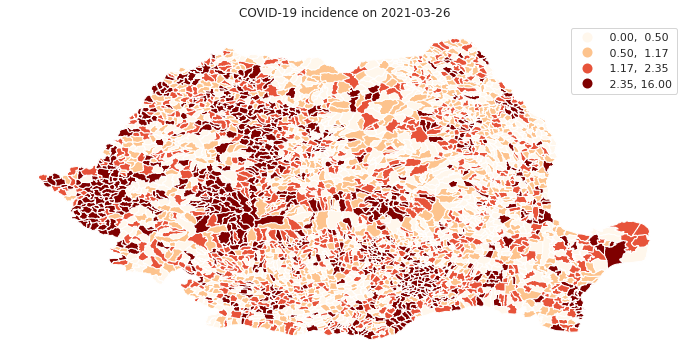

Global Moran I index: 0.40246018604186296 
 p-value: 1e-05


(<Figure size 720x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c4a149ad0>,
       dtype=object))

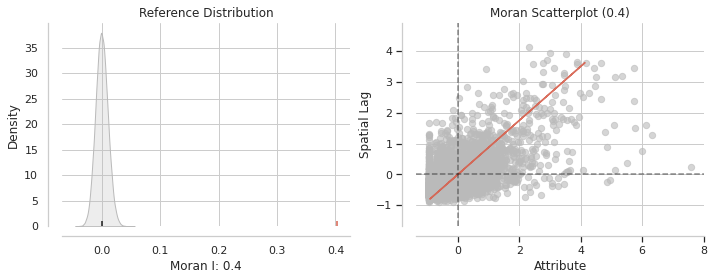

(<Figure size 1080x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1c4ab3b650>,
       dtype=object))

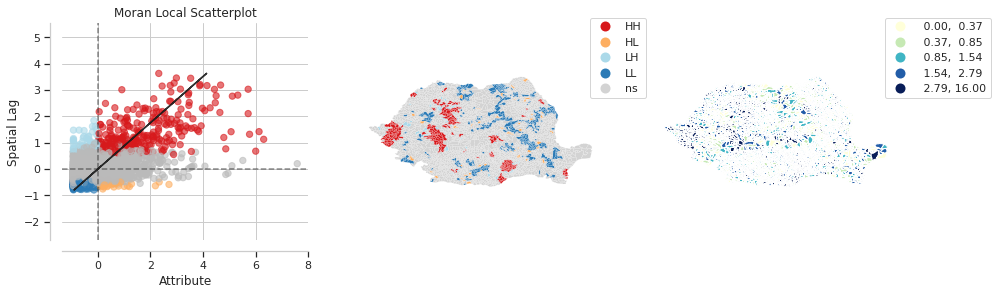

Computing global Moran I index for 2021-03-27
Computing global Moran I index for 2021-03-28
Computing global Moran I index for 2021-03-29
Computing global Moran I index for 2021-03-30
Computing global Moran I index for 2021-03-31
Computing global Moran I index for 2021-04-01
Computing global Moran I index for 2021-04-02
Computing global Moran I index for 2021-04-03
Computing global Moran I index for 2021-04-04
Computing global Moran I index for 2021-04-05
Computing global Moran I index for 2021-04-06
Computing global Moran I index for 2021-04-07
Computing global Moran I index for 2021-04-08
Computing global Moran I index for 2021-04-09
Computing global Moran I index for 2021-04-10
Computing global Moran I index for 2021-04-11
Computing global Moran I index for 2021-04-12
Computing global Moran I index for 2021-04-13
Computing global Moran I index for 2021-04-14
Computing global Moran I index for 2021-04-15
Computing global Moran I index for 2021-04-16
Computing global Moran I index for

In [28]:
df = pd.DataFrame(columns = ["date", "moran_i", "p_val"])
for day in (covid_df.date.unique()):
  daystr = (str(day))
  daystr = daystr[:10]
  day_gdf = covid_df.loc[covid_df['date']==daystr] # slice the dataframe according to the unique values of the 'date' column
  day_gdf = uat_gdf.merge(day_gdf, on=['county', 'uat'])
  day_gdf = gpd.GeoDataFrame(day_gdf)
  print(f'Computing global Moran I index for {daystr}')

  # DEFINE SPATIAL MATRIX
  w_q = Queen.from_dataframe(day_gdf)
  w_q.transform = 'r'
  y = day_gdf['covid_rate'].values

  # GLOBAL SPATIAL AUTOCORRELATION
  moran = Moran(y, w_q, permutations=99999)
  df = df.append({'date': day, 'moran_i': moran.I.item(), "p_val": moran.p_sim.item()}, ignore_index=True)

  if '2021-03-26' in daystr:
    # QUARTILE MAP
    fig, ax = plt.subplots(figsize=(10,7))
    day_gdf.plot(column='covid_rate', scheme='Quantiles', k=4, cmap='OrRd', legend=True, ax=ax);
    plt.tight_layout();
    ax.set_axis_off();
    plt.savefig(f'covid_incidence_{daystr}.png');
    plt.title(f'COVID-19 incidence on {daystr}');
    plt.show();

    # DEFINE SPATIAL MATRIX
    w_q = Queen.from_dataframe(day_gdf)
    w_q.transform = 'r'
    y = day_gdf['covid_rate'].values

    # GLOBAL SPATIAL AUTOCORRELATION
    moran = Moran(y, w_q, permutations=99999)
    print('Global Moran I index:', moran.I, '\n p-value:', moran.p_sim) # get global Moran I index and simulated p value
    plot_moran(moran, zstandard=True, figsize=(10,4)); # plot global Moran I statistics result
    plt.tight_layout();
    plt.show();

    # LOCAL SPATIAL AUTOCORRELATION
    moran_loc = Moran_Local(y, w_q, permutations=99999)
    plot_local_autocorrelation(moran_loc, day_gdf, 'covid_rate')
    plt.show()

In [30]:
df.head()

,date,moran_i,p_val
0,2021-03-01,0.297636,0.00001
1,2021-03-02,0.302468,0.00001
2,2021-03-03,0.306533,0.00001
3,2021-03-04,0.312446,0.00001
4,2021-03-05,0.310921,0.00001


In [31]:
df.to_csv(os.path.join('data', 'global_moran_i_covid_incidence_rates.csv'))

Between 19 March and April 3rd, the autorcorrelation index was above 0.35, so we'll select all values within this interval for further analysis.

In [32]:
# Transform dataframe into a time series
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

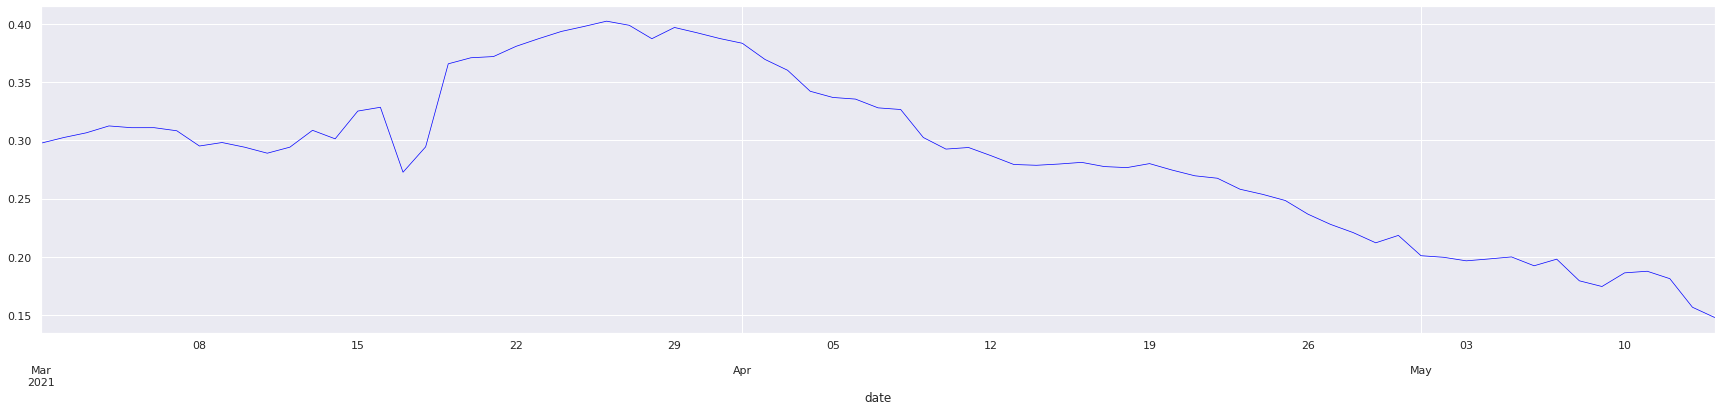

In [33]:
# Plot the daily evolution of the global Moran I index
mean_df = df.groupby('date').mean()
sns.set(rc={'figure.figsize':(30, 6)})
mean_df['moran_i'].plot(linewidth=0.7, color="blue");

When daily moran I's indices are computed for the rate of covid infection, we can see that the overall tendency of clusterization is increasing, hence becomnig stronger between mid March up to mid April, with a peak of such behavior around the end of the month of March.

### Bivariate analysis

In [35]:
unemp_uat_gdf = pd.read_csv(os.path.join('data', 'march_26_covid_unemp.csv'))
unemp_uat_gdf.shape

(3186, 7)

In [36]:
unemp_uat_gdf.head(2)

,county,uat,geometry,covid_rate_march26_21,feb_2021_unemp,siruta,jan_2021_unemp
0,TELEORMAN,NASTURELU,"POLYGON ((25.49428895683132 43.70418534606721,...",1.22,229,153400,209
1,ARAD,ARAD,MULTIPOLYGON (((21.16789153640681 46.052126994...,5.07,989,9262,974


In [40]:
unemp_uat_gdf.drop(columns='geometry', inplace=True)

In [41]:
unemp_uat_gdf.loc[unemp_uat_gdf['county']=='BUCURESTI']

,county,uat,covid_rate_march26_21,feb_2021_unemp,siruta,jan_2021_unemp
3117,BUCURESTI,SECTOR 6,7.36,2512,179196,2501
3168,BUCURESTI,SECTOR 1,9.03,2513,179141,2501
3169,BUCURESTI,SECTOR 2,6.92,2513,179150,2501
3170,BUCURESTI,SECTOR 3,5.74,2512,179169,2501
3171,BUCURESTI,SECTOR 4,6.96,2512,179178,2501
3172,BUCURESTI,SECTOR 5,6.34,2512,179187,2501


In [42]:
# Add a new row to the dataframe for the values corresponding to Bucharest
mean_covid_rate = unemp_uat_gdf.loc[unemp_uat_gdf['county']=='BUCURESTI'].mean()['covid_rate_march26_21']
sum_feb_2021_unemp = unemp_uat_gdf.loc[unemp_uat_gdf['county']=='BUCURESTI'].sum()['feb_2021_unemp']
sum_jan_2021_unemp = unemp_uat_gdf.loc[unemp_uat_gdf['county']=='BUCURESTI'].sum()['jan_2021_unemp']

unemp_uat_gdf.loc[len(unemp_uat_gdf)]=['BUCURESTI', 'BUCURESTI', mean_covid_rate, sum_feb_2021_unemp, 179132, sum_jan_2021_unemp] # add a new row to the geodataframe

In [43]:
# drop sectors
for siruta in [179141, 179150, 179169, 179178, 179187, 179196]:
  unemp_uat_gdf.drop(unemp_uat_gdf.index[unemp_uat_gdf['siruta'] == siruta], inplace=True)
unemp_uat_gdf.shape

(3181, 6)

In [44]:
unemp_uat_gdf.loc[unemp_uat_gdf['county']=='BUCURESTI']

,county,uat,covid_rate_march26_21,feb_2021_unemp,siruta,jan_2021_unemp
3186,BUCURESTI,BUCURESTI,7.058333,15074,179132,15006


### Get the LHDI, vaccinations, covid dataset 

In [107]:
hindex = pd.read_csv(os.path.join('data', 'hindex_interpolated.csv'))
hindex.head(2)
hindex.shape

,siruta,lhdi_2018_pred
0,153400.0,41.0
1,152314.0,40.0


(3181, 2)

### Get the active population dataset 
Data source: INS, data needed prior aggregation

In [115]:
active_pop = pd.read_csv(os.path.join('data', 'employees_pop_age_2021', 'pop_active_2021.csv'))
active_pop.shape
active_pop.head(2)

(3182, 91)

,county,total_pop,siruta,uat,pop_age_0,pop_age_1,pop_age_10,pop_age_11,pop_age_12,pop_age_13,pop_age_14,pop_age_15,pop_age_16,pop_age_17,pop_age_18,pop_age_19,pop_age_2,pop_age_20,pop_age_21,pop_age_22,pop_age_23,pop_age_24,pop_age_25,pop_age_26,pop_age_27,pop_age_28,pop_age_29,pop_age_3,pop_age_30,pop_age_31,pop_age_32,pop_age_33,pop_age_34,pop_age_35,pop_age_36,pop_age_37,pop_age_38,pop_age_39,pop_age_4,pop_age_40,...,pop_age_51,pop_age_52,pop_age_53,pop_age_54,pop_age_55,pop_age_56,pop_age_57,pop_age_58,pop_age_59,pop_age_6,pop_age_60,pop_age_61,pop_age_62,pop_age_63,pop_age_64,pop_age_65,pop_age_66,pop_age_67,pop_age_68,pop_age_69,pop_age_7,pop_age_70,pop_age_71,pop_age_72,pop_age_73,pop_age_74,pop_age_75,pop_age_76,pop_age_77,pop_age_78,pop_age_79,pop_age_8,pop_age_80,pop_age_81,pop_age_82,pop_age_83,pop_age_84,pop_age_85,pop_age_9,pop_age_18_62
0,Arad,174244,9262.0,ARAD,1311.0,1510.0,1577.0,1662.0,1633.0,1597.0,1604,1532.0,1526.0,1390.0,1383.0,1365.0,1550.0,1451.0,1473.0,1468.0,1490.0,1460.0,1496.0,1687.0,1769,1918.0,2166.0,1585.0,2348.0,2698,2964,2956,2849.0,2727.0,2645.0,2338,2759,2961,1530.0,2970,...,3409.0,3741.0,3580.0,1886,1887,1868,1849.0,1882,2053.0,1421.0,2046,2274,2499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1399.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1522.0,NaN,NaN,NaN,NaN,NaN,2985,1510.0,108795.0
1,Arad,8113,9459.0,CHISINEU-CRIS,63.0,78.0,68.0,70.0,92.0,90.0,81,101.0,70.0,85.0,77.0,93.0,77.0,101.0,102.0,95.0,104.0,102.0,87.0,74.0,94,92.0,88.0,90.0,105.0,118,120,108,105.0,88.0,85.0,92,111,123,81.0,141,...,149.0,181.0,128.0,80,87,93,85.0,102,77.0,75.0,102,103,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,114,59.0,5010.0


In [116]:
active_pop = active_pop[['total_pop', 'siruta', 'pop_age_18_62']]
active_pop.head(2)

,total_pop,siruta,pop_age_18_62
0,174244,9262.0,108795.0
1,8113,9459.0,5010.0


In [117]:
active_pop = active_pop.drop_duplicates()
active_pop.shape

(3182, 3)

## Create the final spatial dataset

In [118]:
hindex_gpd = ro_atu.merge(hindex, on='siruta')

In [119]:
hindex_active_pop_gdf = hindex_gpd.merge(active_pop, on='siruta')
hindex_active_pop_gdf.shape
hindex_active_pop_gdf.head(2)

(3181, 5)

,siruta,geometry,lhdi_2018_pred,total_pop,pop_age_18_62
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24...",41.0,2436,1418.0
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581....",40.0,1818,1018.0


In [120]:
unemp_uat_gdf = unemp_uat_gdf[['siruta', 'covid_rate_march26_21', 'feb_2021_unemp', 'jan_2021_unemp']]
hindex_active_pop_unemp_gdf = hindex_active_pop_gdf.merge(unemp_uat_gdf, on='siruta')
hindex_active_pop_unemp_gdf.shape
hindex_active_pop_unemp_gdf.head(2)

(3181, 8)

,siruta,geometry,lhdi_2018_pred,total_pop,pop_age_18_62,covid_rate_march26_21,feb_2021_unemp,jan_2021_unemp
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24...",41.0,2436,1418.0,1.22,229,209
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581....",40.0,1818,1018.0,0.00,156,166


In [121]:
hindex_active_pop_unemp_gdf = hindex_active_pop_unemp_gdf.rename(columns={'total_pop':'population_2021'})
hindex_active_pop_unemp_gdf['unemp_rate_feb_21'] = vaccines_incidence_hindex_unemp_gdf['feb_2021_unemp']/vaccines_incidence_hindex_unemp_gdf['population_2021']
hindex_active_pop_unemp_gdf.head(2)

,siruta,geometry,lhdi_2018_pred,population_2021,pop_age_18_62,covid_rate_march26_21,feb_2021_unemp,jan_2021_unemp,unemp_rate_feb_21
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24...",41.0,2436,1418.0,1.22,229,209,0.094007
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581....",40.0,1818,1018.0,0.00,156,166,0.085809


In [122]:
# Compute some log values
hindex_active_pop_unemp_gdf['covid_rate_march26_21_log'] = np.log(hindex_active_pop_unemp_gdf['covid_rate_march26_21'])
hindex_active_pop_unemp_gdf['unemp_rate_feb_21_log'] = np.log(hindex_active_pop_unemp_gdf['unemp_rate_feb_21'])
hindex_active_pop_unemp_gdf['lhdi_2018_pred_log'] = np.log(hindex_active_pop_unemp_gdf['lhdi_2018_pred'])

In [123]:
# Replace missing values with 0
hindex_active_pop_unemp_gdf['pop_age_18_62'].isnull().values.any()
hindex_active_pop_unemp_gdf['pop_age_18_62'] = hindex_active_pop_unemp_gdf['pop_age_18_62'].fillna(0)

True

In [124]:
# Compute the active population rate
hindex_active_pop_unemp_gdf['pop_age_18_62_rate'] = vaccines_incidence_hindex_unemp_gdf['pop_age_18_62']/vaccines_incidence_hindex_unemp_gdf['population_2021']

## Spatial Analysis

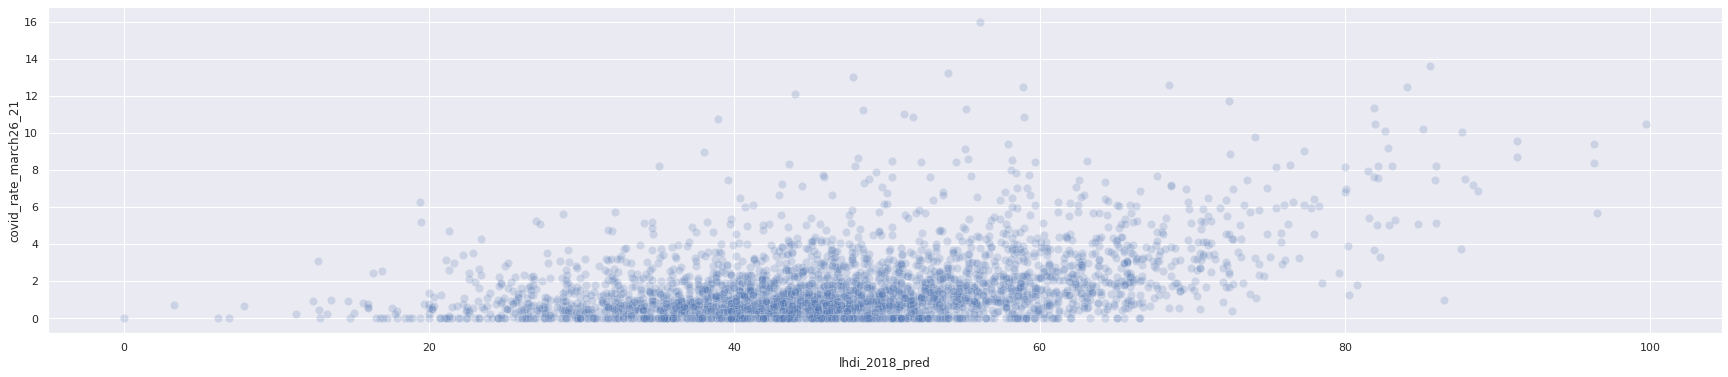

In [89]:
sns.scatterplot(data=hindex_active_pop_unemp_gdf, x="lhdi_2018_pred", y="covid_rate_march26_21", alpha=0.2, s=70, legend= True)

Model the spatial relation between unemployment (considered a proxy for development) and covid-19 rate for the peak of the third wave in Romania.

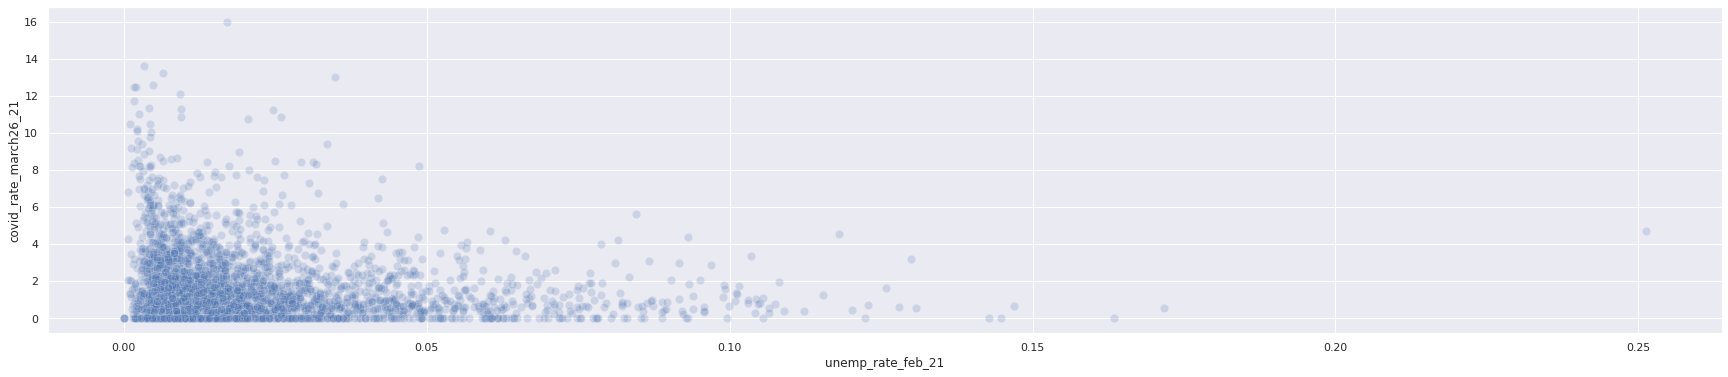

In [90]:
sns.scatterplot(data=hindex_active_pop_unemp_gdf, x="unemp_rate_feb_21", y="covid_rate_march26_21", alpha=0.2, s=70, legend= True)

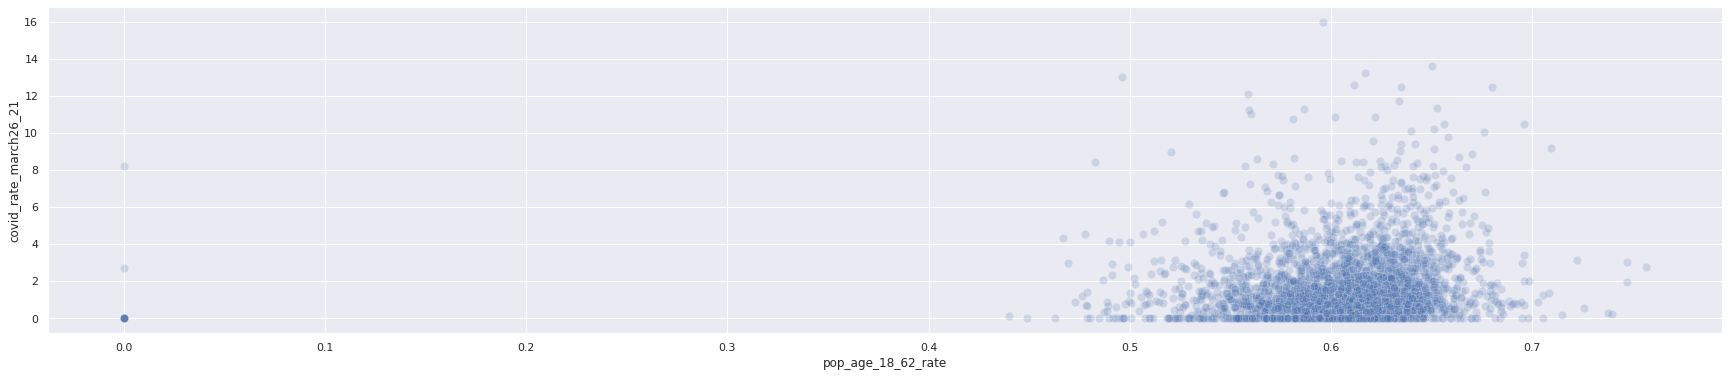

In [126]:
sns.scatterplot(data=hindex_active_pop_unemp_gdf, x="pop_age_18_62_rate", y="covid_rate_march26_21", alpha=0.2, s=70, legend= True)

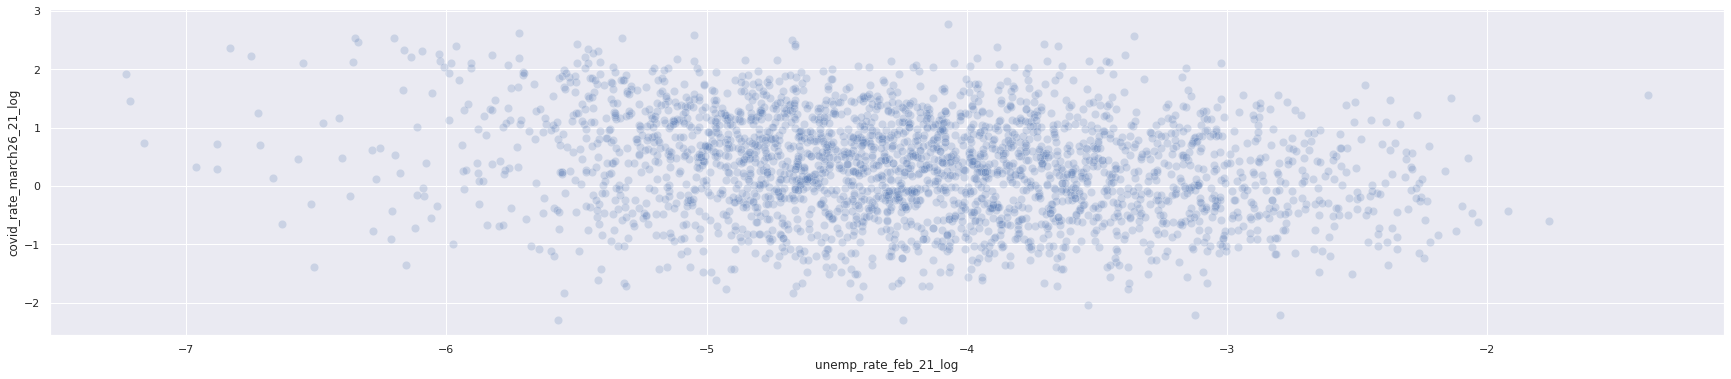

In [91]:
sns.scatterplot(data=hindex_active_pop_unemp_gdf, x="unemp_rate_feb_21_log", y="covid_rate_march26_21_log", alpha=0.2, s=70, legend= True)

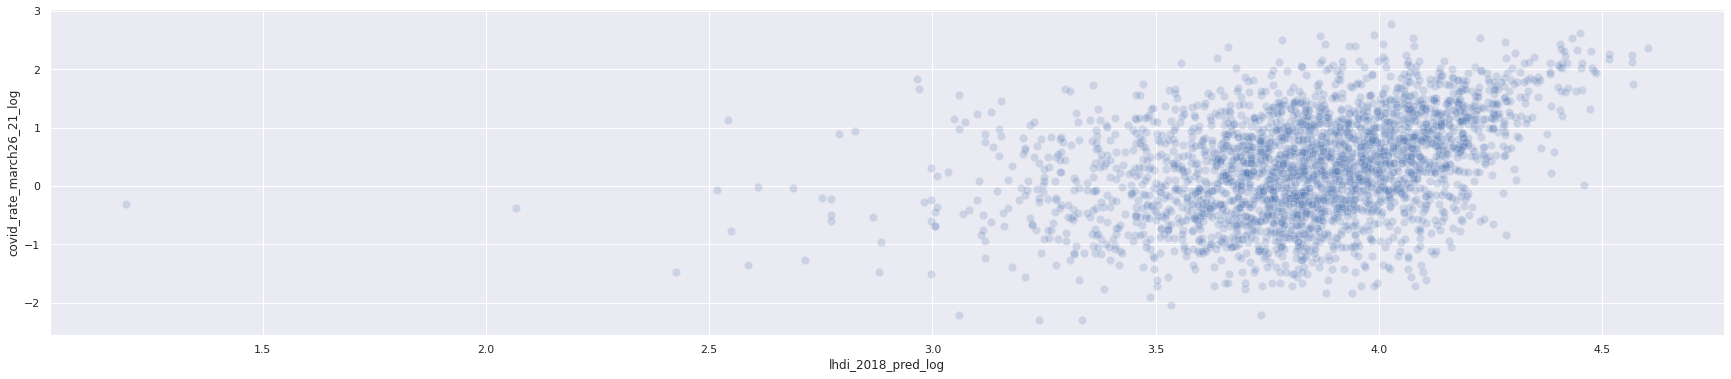

In [92]:
sns.scatterplot(data=hindex_active_pop_unemp_gdf, x="lhdi_2018_pred_log", y="covid_rate_march26_21_log", alpha=0.2, s=70, legend= True)

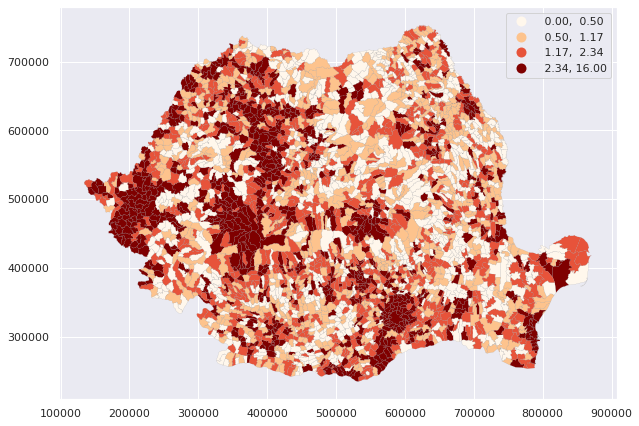

In [93]:
plt = hindex_active_pop_unemp_gdf.plot(column=hindex_active_pop_unemp_gdf['covid_rate_march26_21'], scheme='Quantiles', k=4, cmap='OrRd',  figsize=(10, 10), edgecolor='gray',  linewidth=0.1, legend=True)

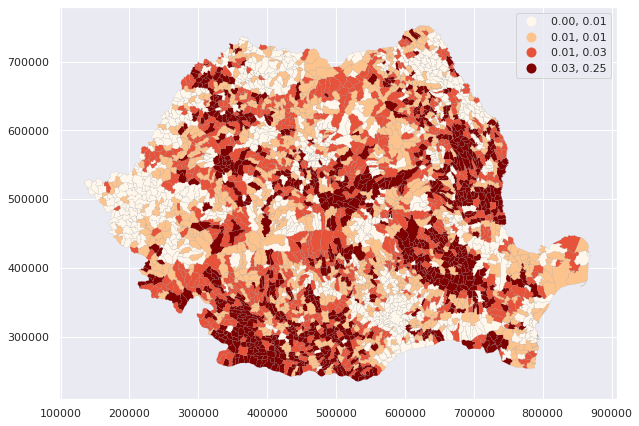

In [94]:
plt = hindex_active_pop_unemp_gdf.plot(column=hindex_active_pop_unemp_gdf['unemp_rate_feb_21'], scheme='Quantiles',  k=4, cmap='OrRd',  figsize=(10, 10), edgecolor='gray',  linewidth=0.1, legend=True)

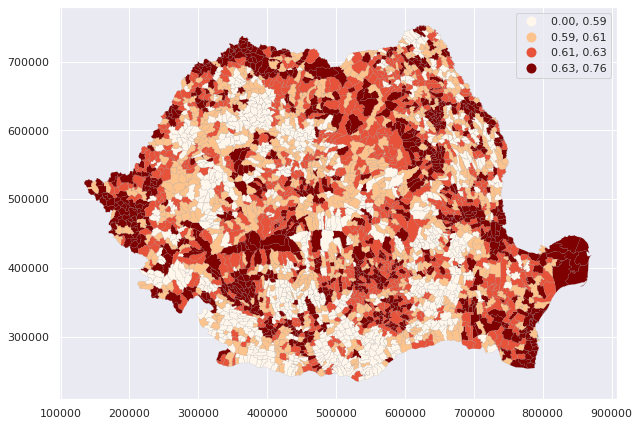

In [125]:
plt = hindex_active_pop_unemp_gdf.plot(column=hindex_active_pop_unemp_gdf['pop_age_18_62_rate'], scheme='Quantiles',  k=4, cmap='OrRd',  figsize=(10, 10), edgecolor='gray',  linewidth=0.1, legend=True)

In [ ]:
plt = hindex_active_pop_unemp_gdf.plot(column=hindex_active_pop_unemp_gdf['lhdi_2018_pred'], scheme='Quantiles',  k=4, cmap='OrRd',  figsize=(10, 10), edgecolor='gray',  linewidth=0.1, legend=True)

In [96]:
hindex_active_pop_unemp_gdf.describe()

,siruta,incidence_04_07,population_2020,dose_1,lhdi_2018_pred,population_2021,pop_age_18_62,covid_rate_march26_21,feb_2021_unemp,jan_2021_unemp,unemp_rate_feb_21,covid_rate_march26_21_log,unemp_rate_feb_21_log,lhdi_2018_pred_log,pop_age_18_62_rate
count,3181.000000,3181.000000,3.181000e+03,3181.000000,3.181000e+03,3.181000e+03,3.181000e+03,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3180.000000,3181.000000
mean,94797.463062,1.966675,6.969601e+03,1294.948130,4.723895e+01,6.944109e+03,4.342196e+03,1.724476,91.863879,92.253379,0.021827,-inf,-inf,3.815887,0.604158
std,50664.661840,1.938553,4.297404e+04,12731.491989,1.267622e+01,4.303111e+04,2.705305e+04,1.869476,294.818103,293.500875,0.020970,NaN,NaN,0.294721,0.051984
min,1017.000000,0.000000,1.210000e+02,8.000000,-3.547850e-13,1.210000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-inf,-inf,1.193922,0.000000
25%,51699.000000,0.630000,2.029000e+03,156.000000,3.920000e+01,2.011000e+03,1.199000e+03,0.500000,27.000000,27.000000,0.008364,-0.693147,-4.783839,3.668677,0.585662
50%,96593.000000,1.420000,3.061000e+03,273.000000,4.650000e+01,3.040000e+03,1.855000e+03,1.170000,51.000000,52.000000,0.014795,0.157004,-4.213434,3.839452,0.610193
75%,139330.000000,2.760000,4.910000e+03,502.000000,5.530000e+01,4.870000e+03,2.997000e+03,2.340000,98.000000,98.000000,0.027302,0.850151,-3.600782,4.012773,0.630222
max,180091.000000,17.290000,2.151665e+06,644973.000000,9.970000e+01,2.158169e+06,1.353367e+06,16.000000,15074.000000,15006.000000,0.251205,2.772589,-1.381484,4.602166,0.756369


## 4. Spatial models

In [71]:
# utils
def compute_basic_spatial_models(y, x, w, name_y, name_x, name_w, name_ds):
# OLS ROBUST WHITE
  m1_robust_white = spreg.OLS(y, x, w=w, spat_diag=True, white_test=True, moran=True, name_y=name_y, name_x=name_x, robust='white', name_w=name_w, name_ds=name_ds)
  print(m1_robust_white.summary)

  print('GMM method for a spatial error model, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].')
  # SPATIAL ERROR
  m2 = spreg.GM_Error(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m2.summary)

  print('Spatial two stage least squares (S2SLS) with results and diagnostics; Anselin (1988) [Ans88]')
  # SPATIAL LAG
  m3 = spreg.GM_Lag(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m3.summary)

  print('ML estimation of the spatial lag model with all results and diagnostics; [Ans88]')
  m4 = spreg.ML_Lag(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m4.summary)

  print('ML estimation of the spatial error model with all results and diagnostics; [Ans88]')
  m5 = spreg.ML_Error(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m5.summary)

  print('GMM method for a spatial lag and error model with endogenous variables, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].')
  # COMBINED
  m6 = spreg.GM_Combo(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m6.summary)

  print('GMM method for a spatial lag and error model with heteroskedasticity and endogenous variables, with results and diagnostics; based on [ADKP10], following [Ans11].')
  m7 = spreg.GM_Combo_Het(y, x, w=w, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
  print(m7.summary)

In [ ]:
# DEFINE SPATIAL MATRIX
w_q.transform = 'r

In [67]:
# DEFINE X, Y
y = hindex_active_pop_unemp_gdf[['covid_rate_march26_21']].values
x = hindex_active_pop_unemp_gdf[['unemp_rate_feb_21']].values

NAME_X = ['unemp_rate_feb_21']
NAME_Y = 'covid_rate_march26_21'
NAME_DATASET = 'unemployment_covid_rates'
NAME_W = 'Q row std'

compute_basic_spatial_models(y, x, w=w_q, name_y=NAME_Y, name_x=NAME_X, name_w=NAME_W, name_ds=NAME_DATASET)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :unemployment_covid_rates
Weights matrix      :   Q row std
Dependent Variable  :covid_rate_march26_21                Number of Observations:        3181
Mean dependent var  :      1.7245                Number of Variables   :           2
S.D. dependent var  :      1.8695                Degrees of Freedom    :        3179
R-squared           :      0.0301
Adjusted R-squared  :      0.0298
Sum squared residual:   10778.890                F-statistic           :     98.8058
Sigma-square        :       3.391                Prob(F-statistic)     :       6e-23
S.E. of regression  :       1.841                Log likelihood        :   -6454.680
Sigma-square ML     :       3.389                Akaike info criterion :   12913.360
S.E of regression ML:      1.8408                Schwarz criterion     :   12925.490

White Standard Errors
----------------------------------

Model the spatial relation between Local Human Developement Index (LHDI, updated by Sandu D. 2020 and interpolated for the spatial units in which the index was not computed - all ATUs where the population is less than 1000) and Covid-19 rate for the peak of the third wave in Romania.

In [75]:
# DEFINE X, Y
y = hindex_active_pop_unemp_gdf[['covid_rate_march26_21']].values
x = hindex_active_pop_unemp_gdf[['lhdi_2018_pred']].values

NAME_X = ['lhdi_2018']
NAME_Y = 'covid_rate_march26_21'

compute_basic_spatial_models(y, x, w=w_q, name_y=NAME_Y, name_x=NAME_X, name_w=NAME_W, name_ds=NAME_DATASET)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :lhdi_covid_rates
Weights matrix      :   Q row std
Dependent Variable  :covid_rate_march26_21                Number of Observations:        3181
Mean dependent var  :      1.7245                Number of Variables   :           2
S.D. dependent var  :      1.8695                Degrees of Freedom    :        3179
R-squared           :      0.1793
Adjusted R-squared  :      0.1790
Sum squared residual:    9121.622                F-statistic           :    694.3363
Sigma-square        :       2.869                Prob(F-statistic)     :  1.422e-138
S.E. of regression  :       1.694                Log likelihood        :   -6189.159
Sigma-square ML     :       2.868                Akaike info criterion :   12382.318
S.E of regression ML:      1.6934                Schwarz criterion     :   12394.448

White Standard Errors
------------------------------------------

Model the spatial relation between the active population rate (population aged 18-64, as a proxy for development) and Covid-19 rate for the peak of the third wave in Romania.

In [88]:
# DEFINE X, Y
y = hindex_active_pop_unemp_gdf[['covid_rate_march26_21']].values
x = hindex_active_pop_unemp_gdf[['pop_age_18_62_rate']].values

NAME_X = ['rate_active_population']
NAME_Y = 'covid_rate_march26_21'

compute_basic_spatial_models(y, x, w=w_q, name_y=NAME_Y, name_x=NAME_X, name_w=NAME_W, name_ds=NAME_DATASET)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :lhdi_covid_rates
Weights matrix      :   Q row std
Dependent Variable  :covid_rate_march26_21                Number of Observations:        3181
Mean dependent var  :      1.7245                Number of Variables   :           2
S.D. dependent var  :      1.8695                Degrees of Freedom    :        3179
R-squared           :      0.0105
Adjusted R-squared  :      0.0102
Sum squared residual:   10996.680                F-statistic           :     33.8887
Sigma-square        :       3.459                Prob(F-statistic)     :   6.417e-09
S.E. of regression  :       1.860                Log likelihood        :   -6486.496
Sigma-square ML     :       3.457                Akaike info criterion :   12976.992
S.E of regression ML:      1.8593                Schwarz criterion     :   12989.122

White Standard Errors
------------------------------------------